/tmp/ipython-input-1344566193.py:21: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['datetime'] = pd.to_datetime(df['time'], unit='s')


Random Forest eğitiliyor...
KNN eğitiliyor...
------------------------------
RANDOM FOREST SONUÇLARI
R2 Score: 0.5567
MAE (Ortalama Hata): 0.3437
------------------------------
KNN SONUÇLARI
R2 Score: 0.4745
MAE (Ortalama Hata): 0.3632


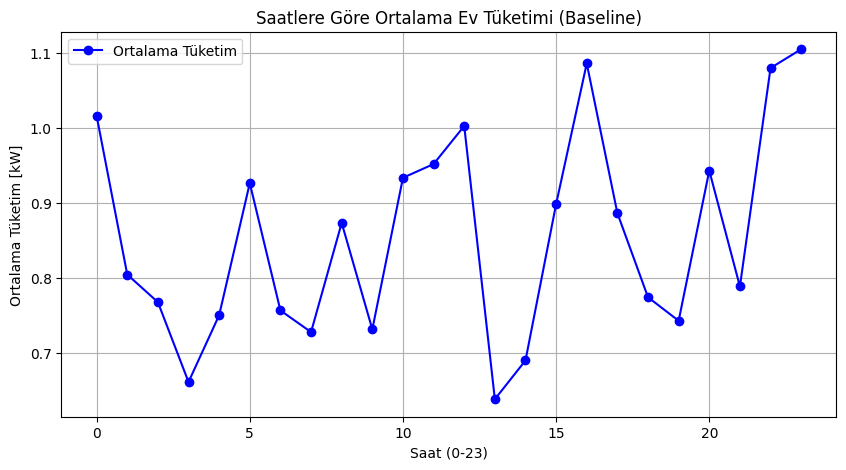

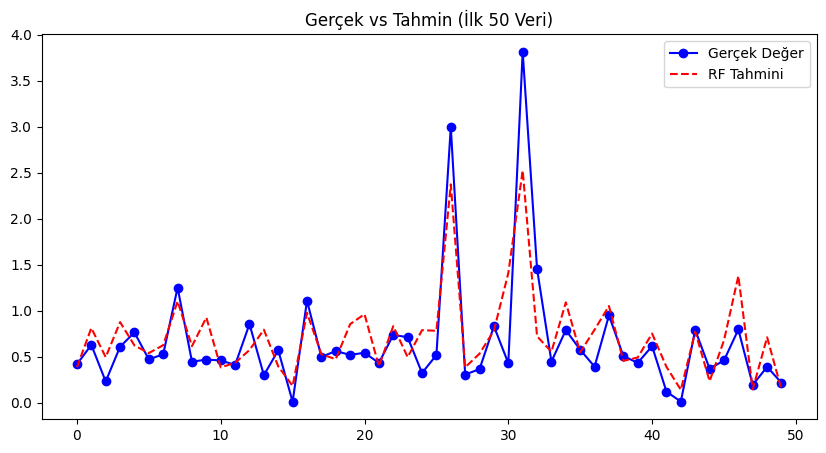

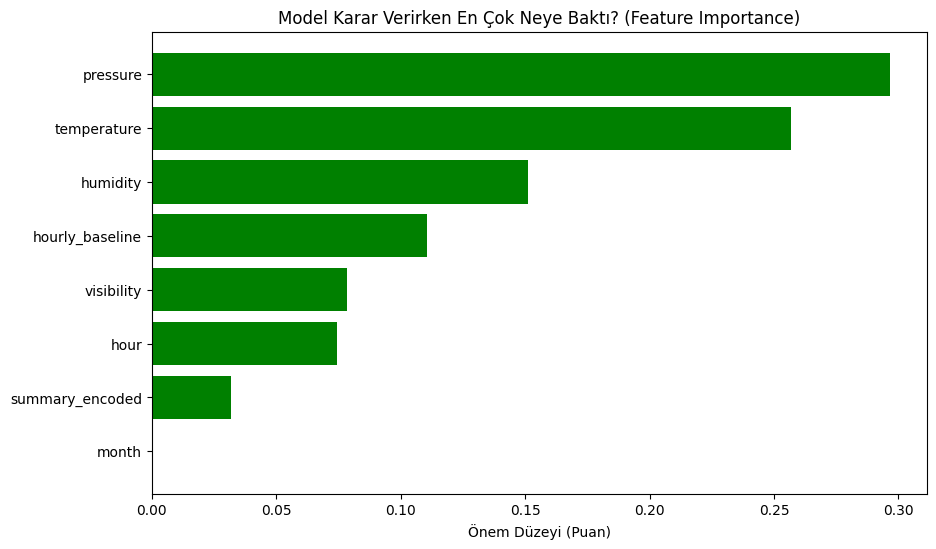

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# dosyayı oku
df = pd.read_csv("Smart Home Dataset.csv", low_memory=False)

# veri ön işleme

# eksik verileri atıyoruz
df.dropna(inplace=True)

# 'time' sutünu unix formatında, bunu anlaşılır saate çevirdim
df['datetime'] = pd.to_datetime(df['time'], unit='s')
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month

# pivot table
# amac her saatin normal tüketimini bulup modele öğretmek
baseline_pivot = df.pivot_table(index="hour", values="use [kW]", aggfunc="mean")

# olusturdğumuz bu pivot tablodaki ortalamaları ana veriye ekledim
df["hourly_baseline"] = df["hour"].map(baseline_pivot["use [kW]"])

# kategorik verileri sayıya çevirdim (label encoding)
le = LabelEncoder()
df["summary_encoded"] = le.fit_transform(df["summary"].astype(str))
df["icon_encoded"] = le.fit_transform(df["icon"].astype(str))

# model hazırılığı

# modele girecek özellikler (X)
features = ["temperature", "humidity", "visibility", "pressure",
            "hour", "month", "summary_encoded", "hourly_baseline"]

X = df[features]
y = df["use [kW]"] # tahmin edeceğimiz şey

# (%20 test, %80 eğitim)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ilk modelimiz randorm forest
print("Random Forest eğitiliyor...")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# ikinci modelimiz KNN
print("KNN eğitiliyor...")
# scaling işlemi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)

# sonuçlar

print("-" * 30)
print("RANDOM FOREST SONUÇLARI")
print(f"R2 Score: {r2_score(y_test, rf_pred):.4f}")
print(f"MAE (Ortalama Hata): {mean_absolute_error(y_test, rf_pred):.4f}")

print("-" * 30)
print("KNN SONUÇLARI")
print(f"R2 Score: {r2_score(y_test, knn_pred):.4f}")
print(f"MAE (Ortalama Hata): {mean_absolute_error(y_test, knn_pred):.4f}")

# grafiler

# grafik 1
plt.figure(figsize=(10, 5))
plt.plot(baseline_pivot.index, baseline_pivot["use [kW]"], marker='o', color='b', label='Ortalama Tüketim')
plt.title("Saatlere Göre Ortalama Ev Tüketimi (Baseline)")
plt.xlabel("Saat (0-23)")
plt.ylabel("Ortalama Tüketim [kW]")
plt.grid(True)
plt.legend()
plt.show()

# grafik 2
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:50], label="Gerçek Değer", color="blue", marker="o")
plt.plot(rf_pred[:50], label="RF Tahmini", color="red", linestyle="--")
plt.title("Gerçek vs Tahmin (İlk 50 Veri)")
plt.legend()
plt.show()

# grafik3
# random forest modelinin içinden hangi sütun ne kadar önemliydi bilgisini aldık
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Model Karar Verirken En Çok Neye Baktı? (Feature Importance)')
plt.barh(range(len(indices)), importances[indices], color='green', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Önem Düzeyi (Puan)')
plt.show()